In [1]:
#import warnings
#warnings.filterwarnings("ignore")
from models.Exp import Exp_TStransformer
import torch
import torch.nn as nn
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
    
args = dotdict()
# training setting 
args.train_epochs           = 150
args.learning_rate_patience = 15
args.learning_rate_factor   = 0.3
args.learning_rate          = 0.0001
args.use_gpu                = True if torch.cuda.is_available() else False
args.gpu                    = 0
args.optimizer              = "Adam"
args.criterion              = "MSE"
args.batch_size             =  32
args.early_stop_patience    = 60



# model parameters
args.flag                   = "train"
args.late                   = False

args.attention_layer_types  = ["Local","LocalLog","ProbMask"]
args.d_model                = 6*5*len(args.attention_layer_types)

args.embedd_kernel_size     = 3
args.forward_kernel_size    = 1
args.value_kernel_size      = 1
args.causal_kernel_size     = 3
args.d_ff                   = None
args.n_heads                = 5*len(args.attention_layer_types)
args.e_layers               = 4
args.dropout                = 0.1
args.norm                   = "batch"
args.se_block               = False
args.activation             = "relu"
args.output_attention       = True
args.factor                 = 5  # 直接被输入了 目前没有被用到

# loading data


args.data_path              = "CMAPSSData/"
args.Data_id                = "FD001"
args.sequence_length        = 40
args.MAXLIFE                = 120
args.difference             = False
args.diff_periods           = 30
args.normalization          = "znorm"
args.validation             = 0.1


args.predictor_type         = "full"
args.d_layers               = 2
args.lambda_final_pred      = 2
args.lambda_final_smooth    = 1
args.enc_pred_loss          = "MSE"
args.final_pred_loss        = "WeightMSE"
args.final_smooth_loss      = None

c:\users\joezh\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\joezh\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\users\joezh\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
exp = Exp_TStransformer(args)

Use GPU: cuda:0
load the data  CMAPSSData/   FD001
['setting3', 's1', 's5', 's10', 's16', 's18', 's19', 'setting1', 'setting2']
train : the shape of data_X is :  (14870, 40, 15)
load the data  CMAPSSData/   FD001
['setting3', 's1', 's5', 's10', 's16', 's18', 's19', 'setting1', 'setting2']
val : the shape of data_X is :  (1861, 40, 15)
build not late


In [3]:
sum_ = 0
for p in exp.model.parameters():
    temp_sum = 1
    for s in p.shape:
        temp_sum = temp_sum*s
    sum_ = sum_ + temp_sum
sum_

644423

train_steps:  465
test_steps:  59
enc_pred_criterion
final_pred_loss


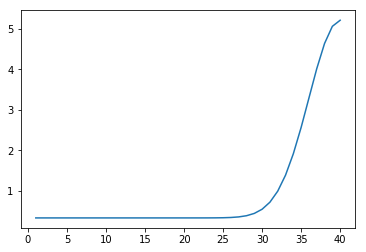

start training
Epoch: 1, Steps: 465 | Train Loss: 20692.5403706 Vali Loss: 14654.0169580. it takse 125.1468303 seconds
Validation loss decreased (inf --> 14654.016958).  Saving model ...


In [ ]:
save_path = "FD001"
exp.train(save_path)

# 结果training上的

In [5]:
best_model_path = "logs/FD001/103.40415734446205_checkpoint.pth"
exp.model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [6]:
for i in exp.vali_loader:
    input_x = i[0].double().to(exp.device)
    gt_y    = i[1].double().to(exp.device)
    break

In [7]:
exp.model.eval()

prediction_y = exp.model(input_x)[0]

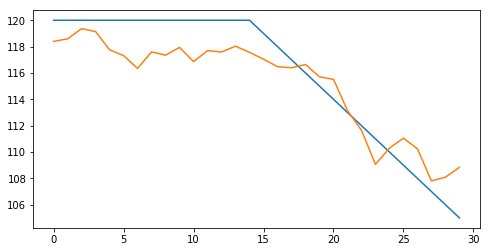

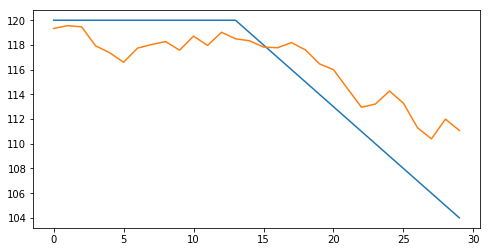

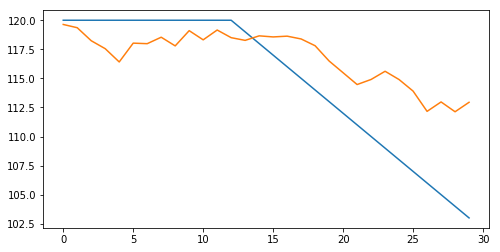

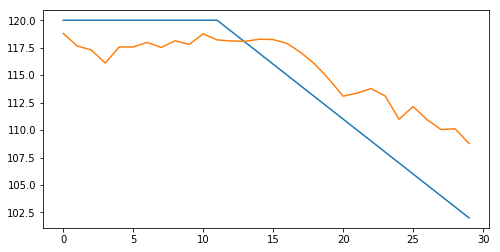

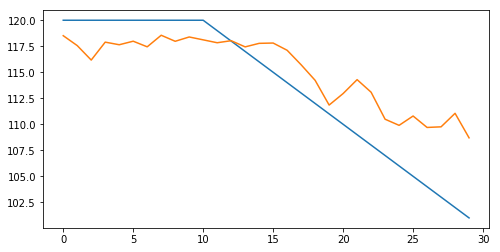

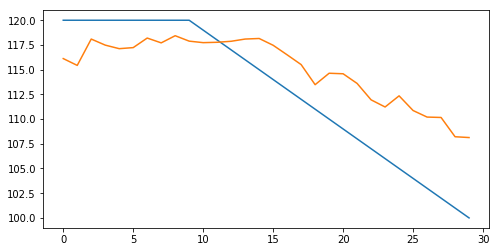

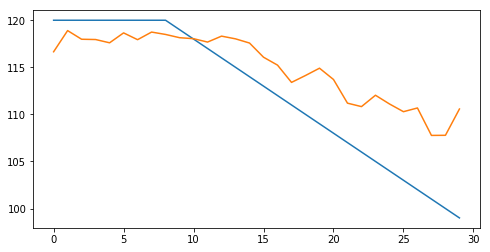

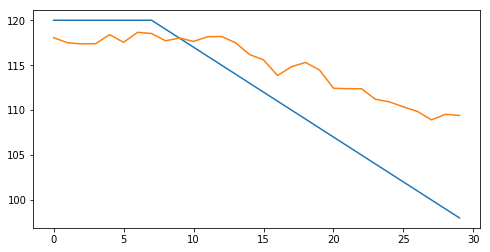

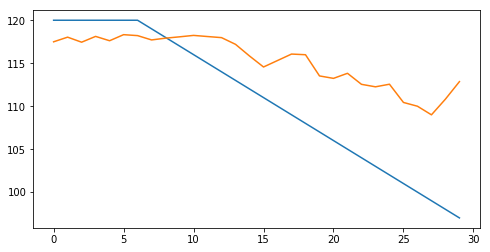

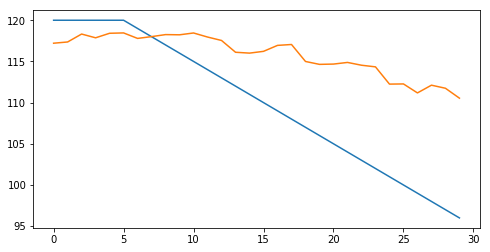

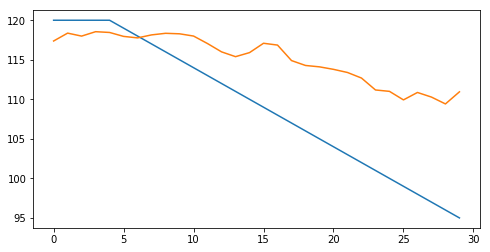

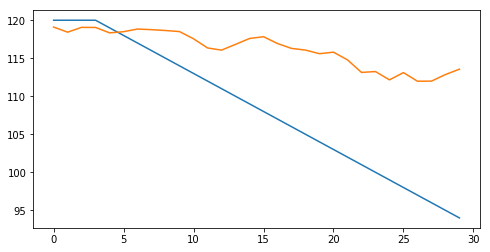

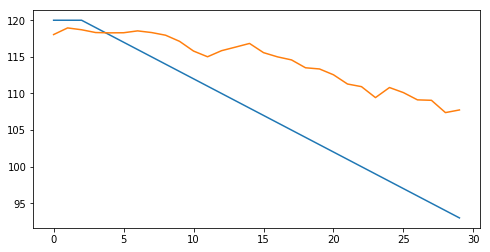

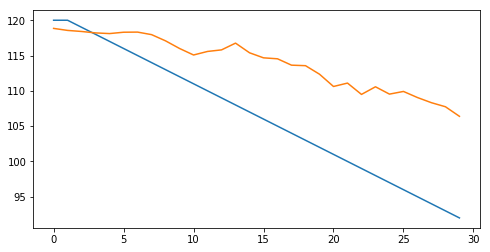

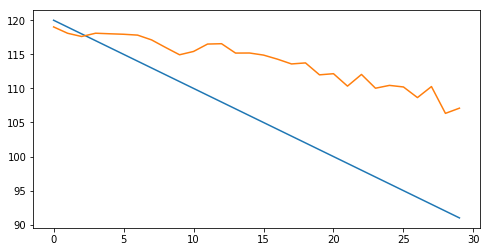

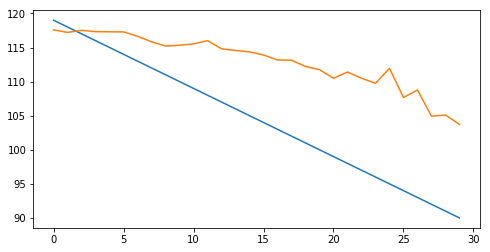

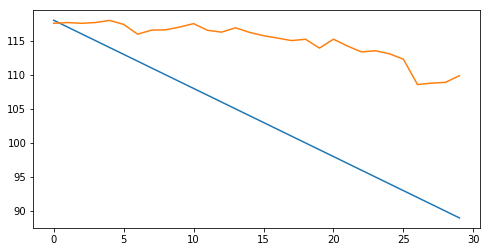

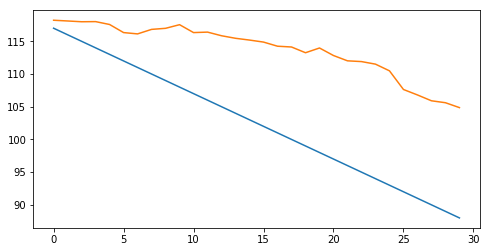

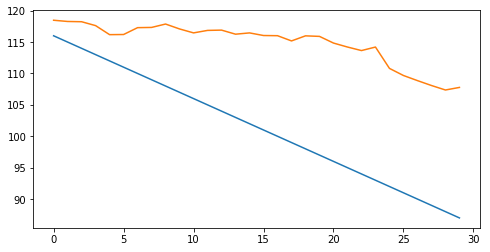

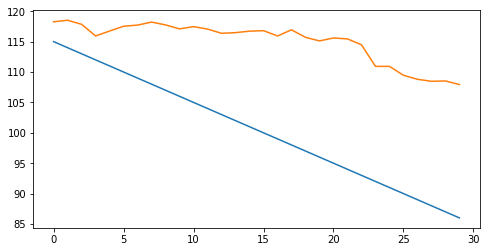

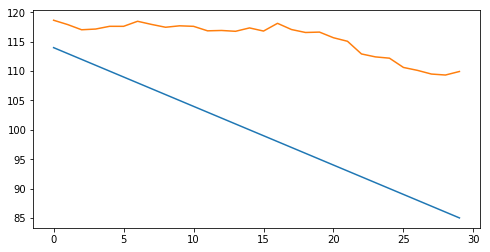

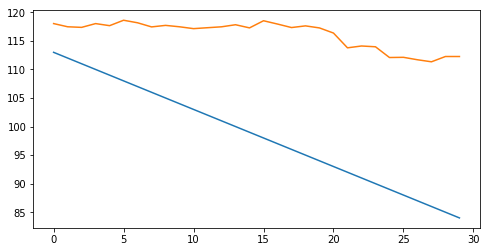

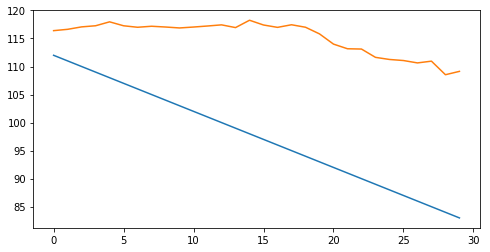

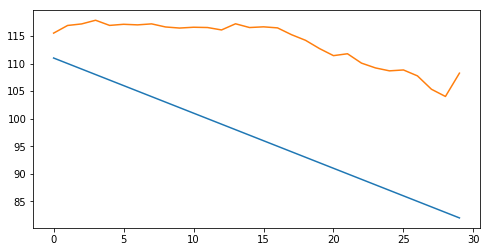

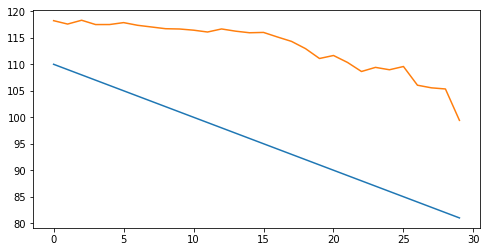

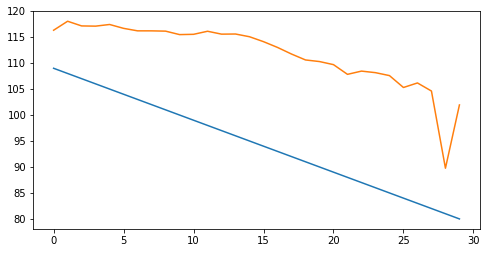

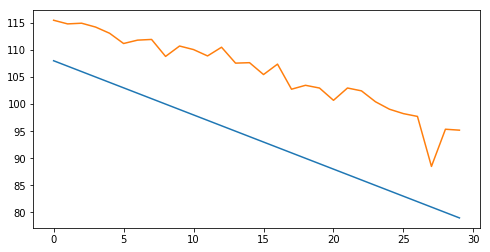

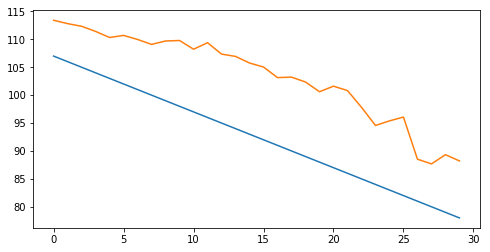

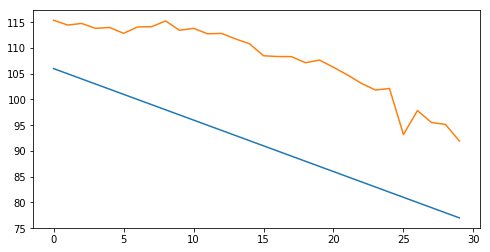

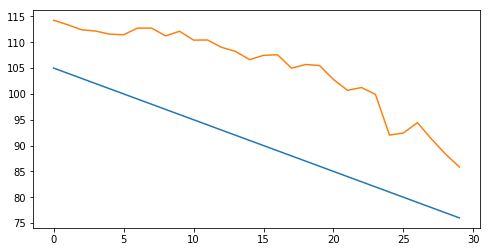

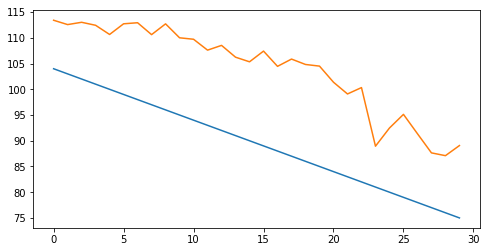

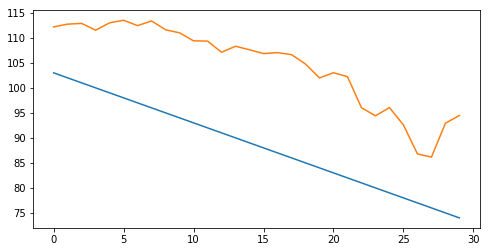

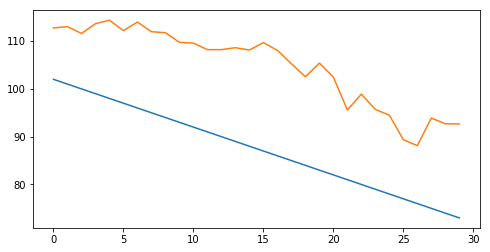

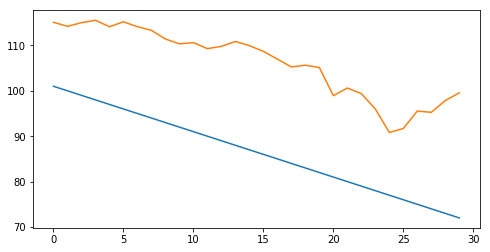

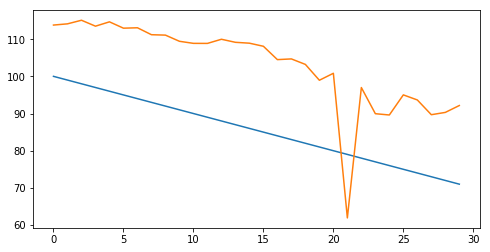

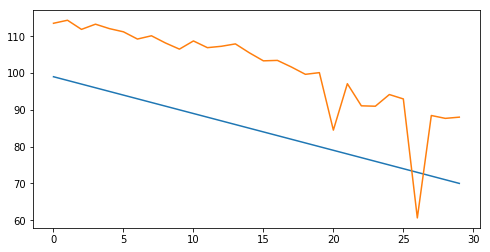

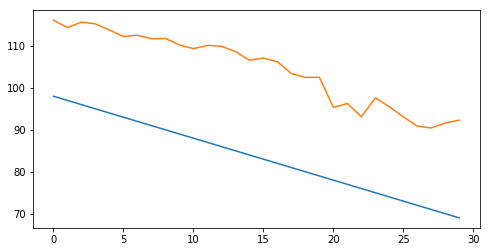

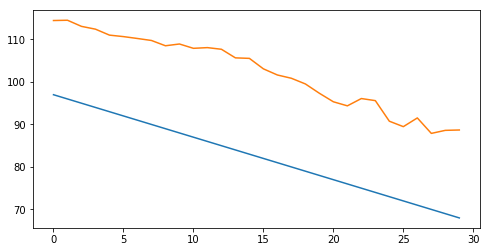

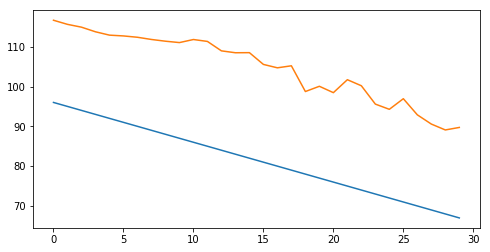

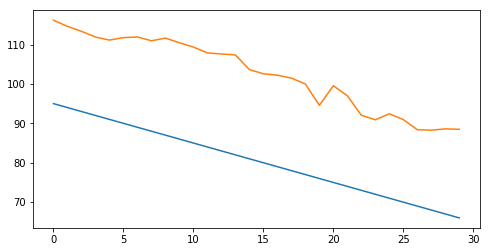

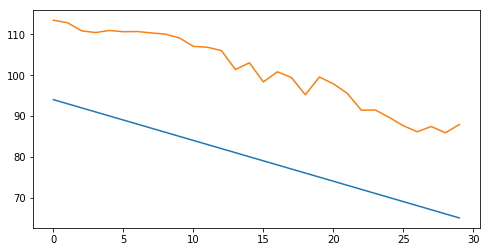

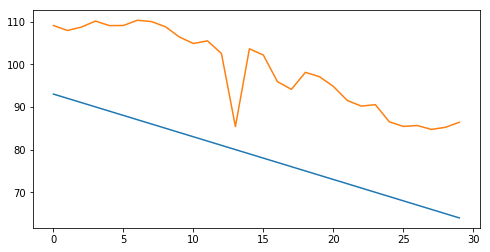

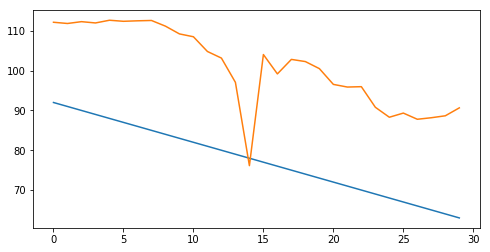

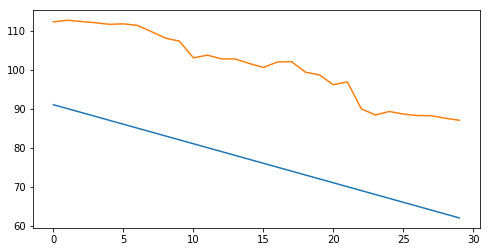

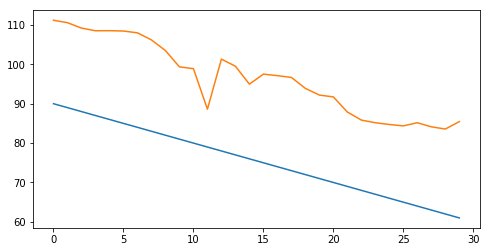

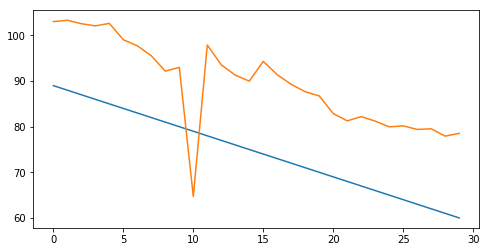

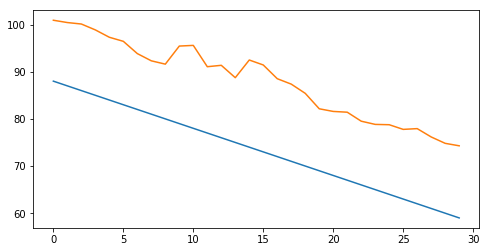

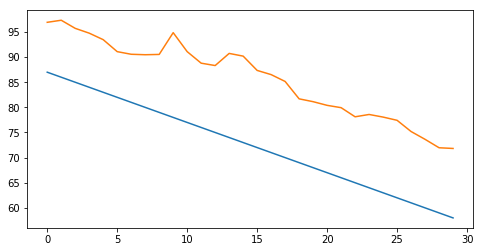

In [8]:
gt_y = gt_y.detach().cpu()
prediction_y = prediction_y.detach().cpu()

import matplotlib.pyplot as plt
for i in range(gt_y.shape[0]):
    plt.figure(figsize=(8,4))
    plt.plot(gt_y[i])
    plt.plot(prediction_y[i])

# test

In [9]:
args.flag   = "test"
args.batch_size = 1
test_exp = Exp_TStransformer(args)
best_model_path = "logs/FD001/103.40415734446205_checkpoint.pth"
test_exp.model.load_state_dict(torch.load(best_model_path))


Use GPU: cuda:0
load the data  CMAPSSData/   FD001
['setting3', 's1', 's5', 's10', 's16', 's18', 's19', 'setting1', 'setting2']
test : the shape of data_X is :  (100, 30, 15)
build not late


<All keys matched successfully>

In [10]:
test_exp.model.eval()
prediction = []
gt = []
for data in test_exp.test_loader:
    batch_x = data[0].double().to(test_exp.device)
    batch_y = data[1].double().to(test_exp.device)

    if args.output_attention:
        outputs = test_exp.model(batch_x)[0]
    else:
        outputs = test_exp.model(batch_x)

    batch_y = batch_y.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    
    gt.append(batch_y)
    prediction.append(outputs)
    


In [11]:
import numpy as np
gt = np.array(gt).reshape(-1,args.sequence_length)
prediction = np.array(prediction).reshape(-1,args.sequence_length)
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(prediction,gt)))
print(np.sqrt(mean_squared_error(prediction[:,-1],gt[:,-1])))

10.655642165212567
13.724543182351157


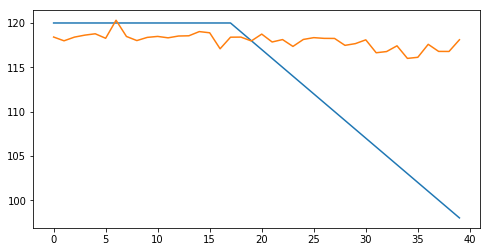

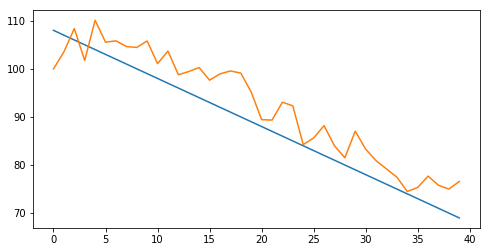

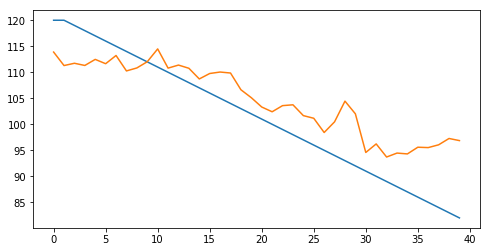

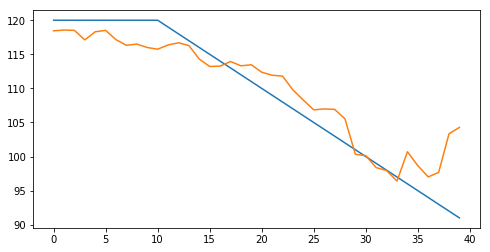

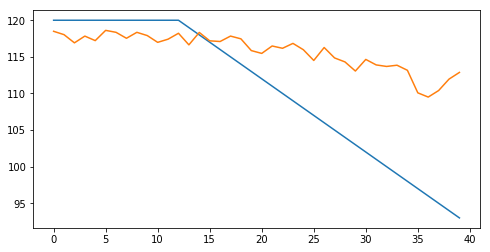

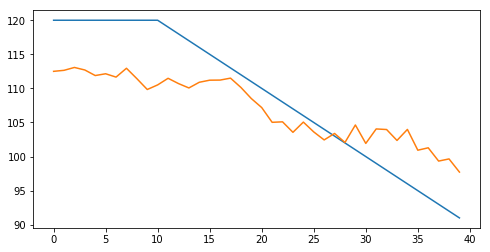

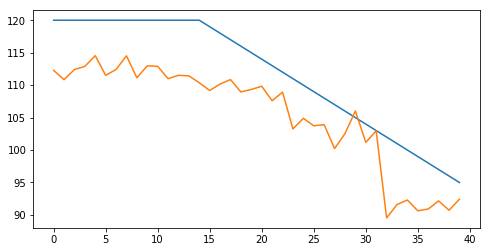

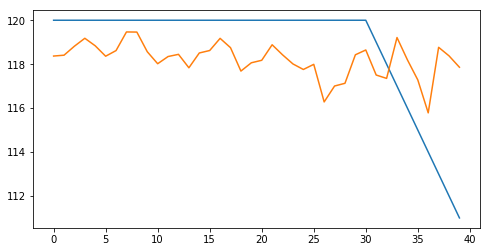

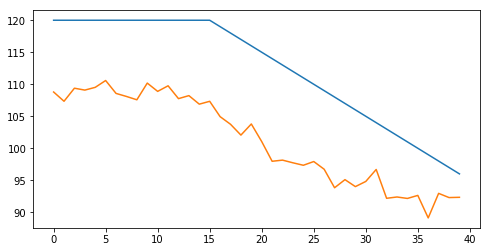

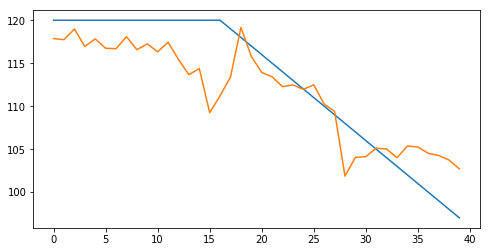

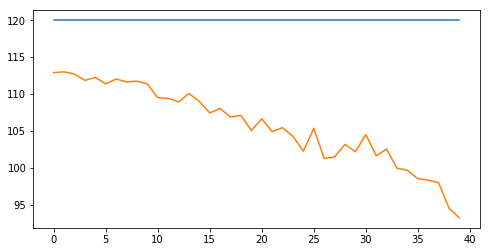

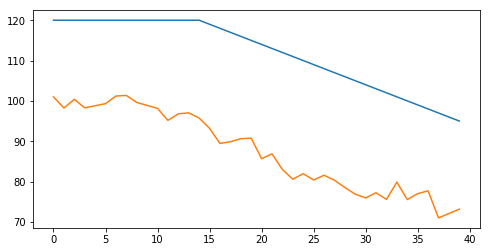

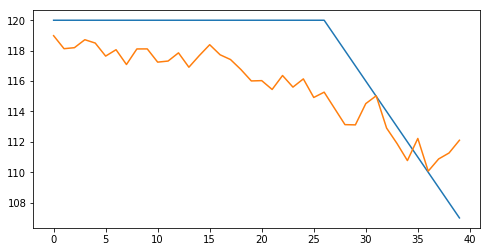

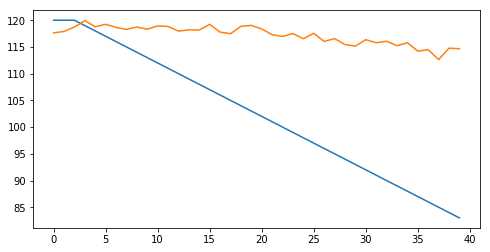

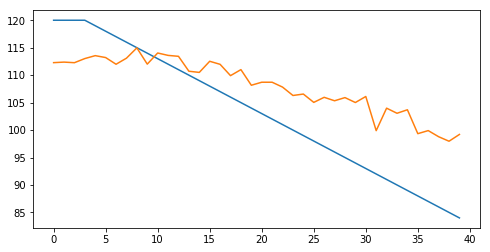

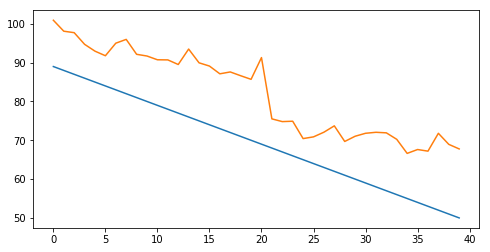

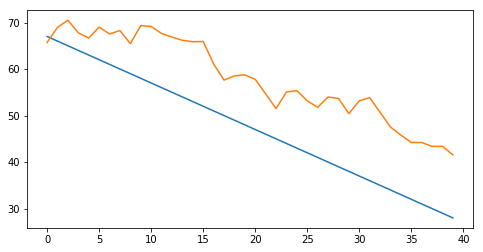

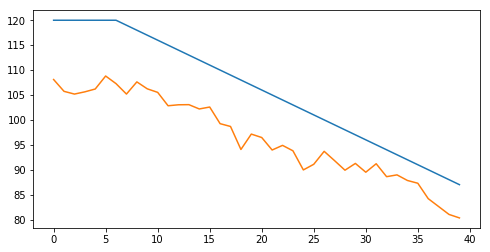

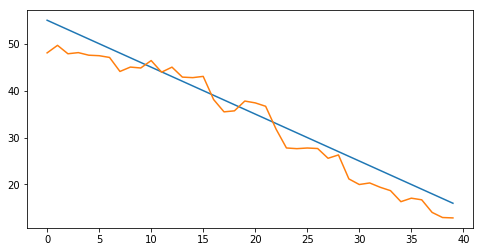

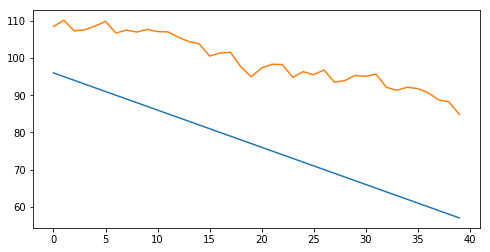

In [12]:
for i in range(20):
    plt.figure(figsize=(8,4))
    plt.plot(gt[i])
    plt.plot(prediction[i])

In [ ]:
#     def test(self, save_path):
#         test_data, test_loader = self._get_data(flag='test')
#         self.model.eval()
        
#         preds = []
#         trues = []
        
#         for i, (batch_x,batch_y) in enumerate(test_loader):
#             batch_x = batch_x.double().to(self.device)
#             batch_y = batch_y.long().to(self.device)

#             # prediction
#             if self.args.output_attention:
#                 outputs = self.model(batch_x)[0]
#             else:
#                 outputs = self.model(batch_x)

            
#             pred = list(np.argmax(outputs.detach().cpu().numpy(),axis=1))
#             true = list(batch_y.detach().cpu().numpy())
            
#             preds.extend(pred)
#             trues.extend(true)

#         preds = np.array(preds)
#         trues = np.array(trues)


#         # result save
#         path = './logs/'+save_path+'/'
#         if not os.path.exists(path):
#             os.makedirs(path)
			
#         df_metrics = calculate_metrics(trues, preds)
#         with open(path+"test_result.pickle", "wb") as f:
#             pickle.dump(df_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         return df_metrics